In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from palettable.colorbrewer.qualitative import Set1_9
import os
from datetime import datetime
from IPython.display import HTML
import seaborn as sns


pwd = os.path.abspath('') + "/"
print(pwd)


c:\Users\jonat\OneDrive\Documents\Active Inference\active_inference_playground\aif_multi_robot\archive/


[0.027028502649974164, 0.04816551072721389, 0.041511940117222916]
Agents have converged to Goal 0 after 12 iterations.
Frame 0


RuntimeError: x must be a sequence

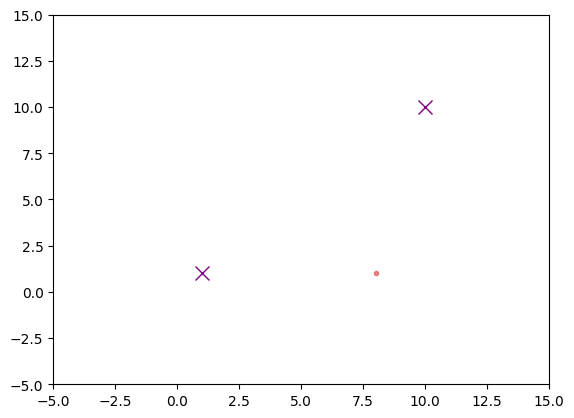

In [15]:
# Colormap
cmap = sns.color_palette("Set1", 9)
# Re-define the environment and simulation parameters here
goals = np.array([[1, 1], [10, 10]], dtype=float)  # Goal positions
agent_positions = np.array([[9, 1], [1, 9], [4,4]], dtype=float)  # Initial agent positions
num_agents = agent_positions.shape[0]  # Number of agents
velocity_options = [0, 0.1, 0.5, 1.0]  # Velocity options for the agents
heading_options = np.linspace(-np.pi,np.pi,12)  # Heading options (radians)
observation_error_std = 3.0  # Observation noise standard deviation
max_iterations = 100  # Maximum number of iterations

# Initialize figure for plotting
fig, ax = plt.subplots()
plt.xlim(-5, 15)
plt.ylim(-5, 15)
# Paths (with smaller line width)
agent_paths = [ax.plot([], [], 'o-', markersize=3, linewidth=1, alpha=0.5, color=cmap[i])[0] for i in range(num_agents)]
# Current positions (with larger markers)
agent_markers = [ax.plot([], [], 'o', markersize=10, color=cmap[i])[0] for i in range(num_agents)]
# Plot Goals
goal_plots = [ax.plot(goal[0], goal[1], 'x', markersize=10, color='purple')[0] for goal in goals]

def init():
    """Initialize the background of the plot."""
    for agent_path, agent_marker in zip(agent_paths, agent_markers):
        agent_path.set_data([], [])
        agent_marker.set_data([], [])
    return agent_paths + agent_markers

def update(frame):
    print(f"Frame {frame}")
    """Update the plot for each frame."""    
    decisions = [make_decision(agent_id, agent_positions) for agent_id in range(num_agents)]
    
    # Update positions based on decisions
    for agent_id, (velocity, heading) in enumerate(decisions):
        dx = velocity * np.cos(heading)
        dy = velocity * np.sin(heading)
        agent_positions[agent_id] += np.array([dx, dy])
    
    # Update plot data
    for agent_id, (agent_path, agent_marker) in enumerate(zip(agent_paths, agent_markers)):
        xdata, ydata = agent_path.get_data()
        xnew, ynew = agent_positions[agent_id]
        xdata = np.append(xdata, xnew)
        ydata = np.append(ydata, ynew)
        agent_path.set_data(xdata, ydata)
        agent_marker.set_data(xnew, ynew)
    
    return agent_paths + agent_markers


def simulate_observation(true_position):
    """Simulate noisy observation of another agent's position."""
    observed_position = true_position + np.random.normal(0, observation_error_std, true_position.shape)
    return observed_position

def calculate_kl_divergence(p, q):
    """Calculate KL divergence between two probability distributions."""
    return np.sum(p * np.log(p / q + np.exp(-16)))

def calculate_shannon_entropy(p):
    """Calculate Shannon entropy of a probability distribution."""
    return -np.sum(p * np.log(p))

def predict_agent_position(agent_position, velocity, heading):
    """Predict agent's next position based on chosen velocity and heading."""
    dx = velocity * np.cos(heading)
    dy = velocity * np.sin(heading)
    return agent_position + np.array([dx, dy])

def make_decision(agent_id, agent_positions):
    """Agent decision-making based on active inference to encourage convergence on a shared goal."""
    best_action = None
    best_score = np.inf

    other_agent_ids = range(0,num_agents)
    other_agent_ids = np.delete(other_agent_ids, agent_id)
    other_agent_observed_position = np.zeros((other_agent_ids.shape[0],2))
    for count, other_agent_id in enumerate(other_agent_ids):
        other_agent_observed_position[count] = simulate_observation(agent_positions[other_agent_id])

    for goal in goals:
        # Initialize a score for how attainable each goal seems for both agents
        goal_scores = []

        for velocity in velocity_options:
            for heading in heading_options:
                predicted_position = predict_agent_position(agent_positions[agent_id], velocity, heading)
                
                # Estimate how both agents are aligned with reaching the current goal
                distance_to_goal = np.linalg.norm(predicted_position - goal)
                distance_other_to_goal = np.linalg.norm(other_agent_observed_position - goal).sum(axis=0)

                # Use the sum of both distances as a simple score for this action's alignment with the goal
                goal_alignment_score = distance_to_goal + distance_other_to_goal
                
                goal_scores.append((goal_alignment_score, velocity, heading))

        # Choose the action (for the current goal) that minimizes the combined distance
        best_action_for_goal = min(goal_scores, key=lambda x: x[0])

        # Update best action if this goal is more attainable than previous best
        if best_action_for_goal[0] < best_score:
            best_score = best_action_for_goal[0]
            best_action = best_action_for_goal[1], best_action_for_goal[2]
    
    return best_action


def run_simulation(max_iterations=100):
    """Run the simulation until both agents converge to the same goal or max iterations reached."""
    current_positions = np.copy(agent_positions)
    
    for iteration in range(max_iterations):
        decisions = [make_decision(agent_id, current_positions) for agent_id in range(num_agents)]
        
        # Update agent positions based on their decisions
        for agent_id, (velocity, heading) in enumerate(decisions):
            dx = velocity * np.cos(heading)
            dy = velocity * np.sin(heading)
            current_positions[agent_id] += np.array([dx, dy])
        decided_velocities = [decision[0] for decision in decisions]
        
        # Check if agents have converged to the same goal
        distances_to_goals = [np.linalg.norm(goals - pos, axis=1) for pos in current_positions]
        goal_reached_by_agents = [np.argmin(distances) for distances in distances_to_goals]
        distances_to_selected_goal = [np.min(distances) for distances in distances_to_goals]
        
        if (np.array(distances_to_selected_goal)<0.2).all() and decided_velocities == [0]*num_agents:
            print(distances_to_selected_goal)
            print(f"Agents have converged to Goal {goal_reached_by_agents[0]} after {iteration + 1} iterations.")
            return current_positions, goal_reached_by_agents[0], iteration

    print("Agents did not converge to the same goal within the maximum iterations.")
    return current_positions, None, iteration

# Run the simulation
final_positions, goal_converged, num_frames = run_simulation()
# Create animation
ani = animation.FuncAnimation(fig, update, num_frames, init_func=init, blit=True, repeat=True)

# Save the animation as a video
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
HTML(ani.to_html5_video()) # Use an interactive backend for animation

# ani.save(pwd + "videos/two_goals_choice" + current_time + ".mp4", writer='ffmpeg', fps=3, dpi=300)
# print("Image saved as: ", pwd + "videos/two_goals_choice" + current_time + ".mp4")


[8.881784197001252e-16, 0.04155839711711691, 0.041511940117222916]
Agents have converged to Goal 0 after 15 iterations.


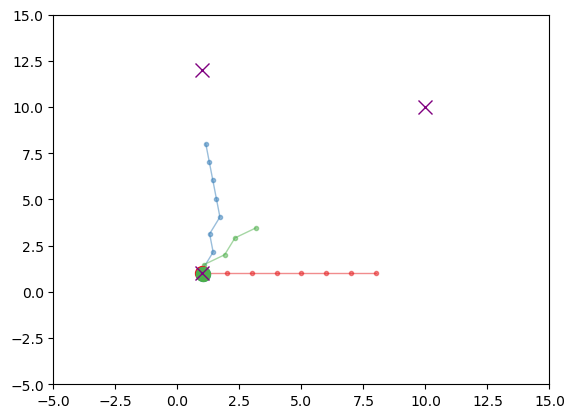

In [4]:
# Re-define the environment and simulation parameters here
goals = np.array([[1, 1], [10, 10],[1,12]], dtype=float)  # Goal positions
agent_positions = np.array([[9, 1], [1, 9],[4,4]], dtype=float)  # Initial agent positions
num_agents = agent_positions.shape[0]  # Number of agents
velocity_options = [0, 0.1, 0.5, 1.0]  # Velocity options for the agents
heading_options = np.linspace(-np.pi,np.pi,12)  # Heading options (radians)
observation_error_std = 3.0  # Observation noise standard deviation
max_iterations = 100  # Maximum number of iterations

# Initialize figure for plotting
fig, ax = plt.subplots()
plt.xlim(-5, 15)
plt.ylim(-5, 15)
# Paths (with smaller line width)
agent_paths = [ax.plot([], [], 'o-', markersize=3, linewidth=1, alpha=0.5, color=cmap[i])[0] for i in range(num_agents)]
# Current positions (with larger markers)
agent_markers = [ax.plot([], [], 'o', markersize=10, color=cmap[i])[0] for i in range(num_agents)]
goal_plots = [ax.plot(goal[0], goal[1], 'x', markersize=10, color='purple')[0] for goal in goals]  # Plot goals

# Run the simulation
final_positions, goal_converged, num_frames = run_simulation()
# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True, repeat=True)

# Save the animation as a video
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
HTML(ani.to_html5_video()) # Use an interactive backend for animation